## Atuação de redes neurais na base de dados do ENEM.

##### Alunos:

-   Gabriel Fonseca (2111066)
-   Yasmim Santos (2116925)
-   Alejandro Elias (2111189)
-   Pedro Lucas (2111131)

Base de dados escolhida - Exame Nacional do Ensino Médio (Enem): https://basedosdados.org/dataset/3e9c8804-c31c-4f48-9a45-d67f1c21a859


In [97]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

### Preparando os dados para utilização no modelo (Redimensionamento, Encodificação e Agrupamento)


In [98]:
df_enem = pd.read_csv(
    f"../data/out/enem-dados-tratados.csv",
    dtype={
        "id_inscricao": np.int64,
        "ensino": int,
        "nota_ciencias_natureza": float,
        "nota_ciencias_humanas": float,
        "nota_linguagens_codigos": float,
        "nota_matematica": float,
        "nota_redacao": float,
        "q_formacao_pai": str,
        "q_formacao_mae": str,
        "q_renda_familia": str,
    },
)

colunas_red = [
    "nota_ciencias_natureza",
    "nota_ciencias_humanas",
    "nota_linguagens_codigos",
    "nota_matematica",
    "nota_redacao",
]

colunas_red_norm = [
    "cn_norm",
    "ch_norm",
    "lc_norm",
    "ma_norm",
    "nr_norm",
]

mm_scaler = MinMaxScaler()
df_enem[colunas_red_norm] = mm_scaler.fit_transform(df_enem[colunas_red])

for col, col_norm in zip(colunas_red, colunas_red_norm):
    df_enem = df_enem[df_enem[col] != 0.0]
    df_enem = df_enem[df_enem[col_norm] != 0.0]

colunas_para_encodificar = [
    "ensino",
    "q_formacao_pai",
    "q_formacao_mae",
    "q_renda_familia",
]

dummies = pd.get_dummies(
    df_enem[colunas_para_encodificar], drop_first=True, dtype=np.int64
)
df_enem = pd.concat([df_enem, dummies], axis=1)

df_enem = df_enem.drop(
    columns=[
        "id_inscricao",
        "ensino",
        "nota_ciencias_natureza",
        "nota_ciencias_humanas",
        "nota_linguagens_codigos",
        "nota_matematica",
        "nota_redacao",
        "q_formacao_pai",
        "q_formacao_mae",
        "q_renda_familia",
        "ano",
    ]
)

df_enem.dropna(inplace=True)
df_enem.reset_index(drop=True, inplace=True)

kmeans_r_state = 43
pca_r_state = 59

df_enem

,cn_norm,ch_norm,lc_norm,ma_norm,nr_norm,q_formacao_pai_B,q_formacao_pai_C,q_formacao_pai_D,q_formacao_pai_E,q_formacao_pai_F,...,q_renda_familia_H,q_renda_familia_I,q_renda_familia_J,q_renda_familia_K,q_renda_familia_L,q_renda_familia_M,q_renda_familia_N,q_renda_familia_O,q_renda_familia_P,q_renda_familia_Q
0,0.420980,0.506492,0.465539,0.333736,0.38,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.587628,0.738349,0.686738,0.553072,0.76,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.540342,0.602017,0.578751,0.353273,0.58,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.565362,0.743334,0.688231,0.654079,0.84,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.543211,0.618363,0.551505,0.450554,0.40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176574,0.458051,0.353698,0.349216,0.372004,0.16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176575,0.836681,0.829121,0.869370,0.861631,0.98,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
176576,0.715024,0.773012,0.802812,0.829305,0.98,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
176577,0.569953,0.465917,0.439662,0.425579,0.28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Observando os intervalos de possíveis números de componentes e selecionando um


In [99]:
pca = PCA(random_state=pca_r_state)
pca.fit(df_enem.to_numpy())
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

n_components = np.argmax(exp_var_cumul >= 0.8) + 1

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
    title=f"Variação explicada por cada componente (Nº componente escolhida: {n_components})",
)

In [100]:
components_columns = ["pc" + str(i) for i in range(1, n_components + 1)]

pca = PCA(n_components=n_components, random_state=pca_r_state)
components = pca.fit_transform(df_enem.to_numpy())
df_new = pd.DataFrame(data=components, columns=components_columns)
df_new.columns = components_columns
df_new.dropna(inplace=True)

### Descobrindo o melhor valor de K (Qtd. de Clusters) com base no método do cotovelo


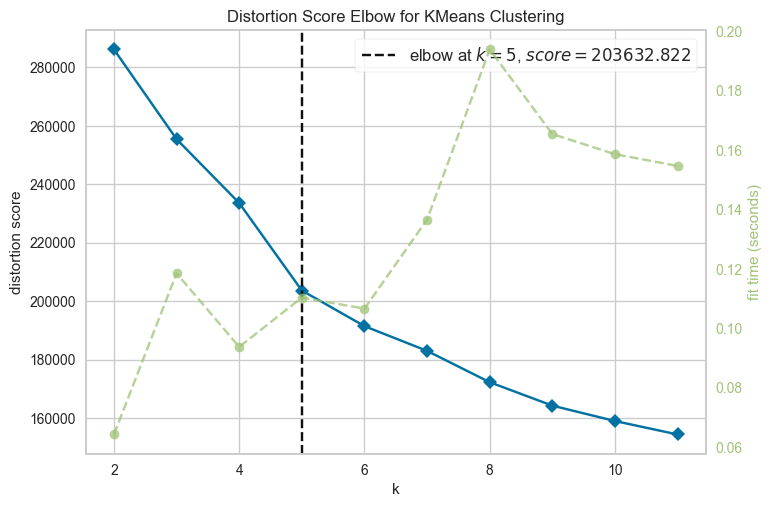

In [101]:
model = KMeans(random_state=kmeans_r_state)
visualizer = KElbowVisualizer(model, k=(2, 12))

X_kmeans = df_new.to_numpy()

visualizer.fit(X_kmeans)

k = visualizer.elbow_value_

_ = visualizer.show()

### Descobrindo o número de componentes com a melhor silhueta.


In [102]:
df_sis = pd.DataFrame(
    columns=["n_components", "silhouette_score"],
)

for i in range(2, 20):
    n_components_teste = i
    components_columns_teste = ["pc" + str(i) for i in range(1, n_components_teste + 1)]

    pca = PCA(n_components=n_components_teste, random_state=pca_r_state)
    components_teste = pca.fit_transform(df_enem.to_numpy())
    df_new_teste = pd.DataFrame(data=components_teste, columns=components_columns_teste)
    df_new_teste.columns = components_columns_teste
    df_new_teste.dropna(inplace=True)

    X_kmeans_teste = df_new_teste.to_numpy()

    kmeans_teste = KMeans(n_clusters=k, random_state=kmeans_r_state)
    kmeans_teste.fit(X_kmeans_teste)

    sil_score = silhouette_score(
        X_kmeans_teste,
        kmeans_teste.labels_,
        metric="euclidean",
        sample_size=50000,
    )

    df_sis.loc[len(df_sis)] = [n_components_teste, sil_score]

# convert n_components column to int
df_sis["n_components"] = df_sis["n_components"].astype(int)
n_components = df_sis.loc[df_sis["silhouette_score"].idxmax()]["n_components"]

df_sis.sort_values(by="silhouette_score", inplace=True, ascending=False)
df_sis

,n_components,silhouette_score
0,2,0.503366
1,3,0.464662
2,4,0.401464
3,5,0.350788
4,6,0.313534
5,7,0.277441
6,8,0.257700
7,9,0.247142
9,11,0.225049
10,12,0.211377


### Preparando o conjunto de dados com o número de componentes escolhido


In [117]:
n_components = 20 # int(n_components)

components_columns = ["pc" + str(i) for i in range(1, n_components + 1)]

pca = PCA(n_components=n_components, random_state=pca_r_state)
components = pca.fit_transform(df_enem.to_numpy())

df_new = pd.DataFrame(data=components, columns=components_columns)
df_new.columns = components_columns
df_new.dropna(inplace=True)

total_var = pca.explained_variance_ratio_.sum()
print(f"Total Variance: {total_var:.2%}")

df_new

Total Variance: 92.70%


,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20
0,0.080772,-0.762073,0.785344,-0.199762,-0.054471,0.049956,0.085057,-0.540187,0.122058,-0.009350,-0.204881,0.117866,0.051369,0.182662,0.045681,-0.155865,-0.028637,0.172294,0.042257,-0.090118
1,-0.393375,-0.548348,0.338719,0.221931,0.016530,-0.173464,-0.307265,-0.246615,-0.040624,-0.236044,0.013224,0.149144,-0.062155,-0.132039,-0.132272,-0.132336,-0.074050,0.376691,0.060337,-0.172838
2,0.776151,0.015068,-0.138434,-0.401179,-0.118827,0.141522,0.238757,-0.504723,0.119789,-0.021885,-0.216869,0.090707,0.061678,-0.005448,0.076559,-0.247858,-0.015698,0.181723,0.028222,-0.091366
3,-0.298046,-0.212125,-0.284790,0.008430,-0.069643,-0.025388,0.005118,0.034027,-0.003384,0.037276,0.015952,-0.047922,-0.000190,-0.154626,-0.041946,0.002010,-0.008484,0.395561,0.166758,-0.128445
4,-0.112868,-0.191350,-0.089860,0.090640,-0.013207,-0.043427,0.032068,0.104094,0.030604,0.156161,0.022738,-0.053985,0.017279,0.184811,-0.046636,0.159181,-0.006575,0.304874,0.173119,-0.099544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176574,0.690036,0.275459,-0.179738,0.192363,0.070071,-0.119768,-0.097106,-0.064469,0.026958,-0.002589,0.017004,0.109595,-0.016944,0.384752,-0.111325,0.104217,-0.056225,0.199506,0.062727,-0.117149
176575,-0.864842,0.316885,-0.248852,-0.297565,-0.790840,-0.036313,-0.041153,-0.010110,0.254096,-0.300749,-0.073484,-0.255992,-0.679908,-0.248120,-0.065714,0.100700,0.162870,-0.217107,0.816525,-0.124461
176576,-0.690970,-0.464786,-0.921494,-0.172441,-0.288681,-0.029161,-0.171939,-0.371105,-0.857431,0.223315,-0.043964,0.255786,0.331872,0.018643,-0.193724,0.179299,-0.010597,-0.154445,-0.128870,0.211709
176577,-0.095767,-0.509821,0.567618,0.561371,0.035605,-0.666054,-0.746402,-0.182829,0.341722,0.691655,-0.216270,-0.045449,0.064493,-0.080547,0.173111,-0.230392,0.019107,0.097194,0.112198,0.354271


### Rotulando os dados com base no agrupamento realizado


In [118]:
X_kmeans = df_new.to_numpy()

kmeans = KMeans(n_clusters=k, random_state=kmeans_r_state)
kmeans.fit(X_kmeans)

df_new["label"] = kmeans.labels_
df_new.to_csv(f"../data/out/enem-dados-tratados-ml.csv", index=False)

df_new

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,label
0,0.080772,-0.762073,0.785344,-0.199762,-0.054471,0.049956,0.085057,-0.540187,0.122058,-0.009350,...,0.117866,0.051369,0.182662,0.045681,-0.155865,-0.028637,0.172294,0.042257,-0.090118,0
1,-0.393375,-0.548348,0.338719,0.221931,0.016530,-0.173464,-0.307265,-0.246615,-0.040624,-0.236044,...,0.149144,-0.062155,-0.132039,-0.132272,-0.132336,-0.074050,0.376691,0.060337,-0.172838,3
2,0.776151,0.015068,-0.138434,-0.401179,-0.118827,0.141522,0.238757,-0.504723,0.119789,-0.021885,...,0.090707,0.061678,-0.005448,0.076559,-0.247858,-0.015698,0.181723,0.028222,-0.091366,2
3,-0.298046,-0.212125,-0.284790,0.008430,-0.069643,-0.025388,0.005118,0.034027,-0.003384,0.037276,...,-0.047922,-0.000190,-0.154626,-0.041946,0.002010,-0.008484,0.395561,0.166758,-0.128445,3
4,-0.112868,-0.191350,-0.089860,0.090640,-0.013207,-0.043427,0.032068,0.104094,0.030604,0.156161,...,-0.053985,0.017279,0.184811,-0.046636,0.159181,-0.006575,0.304874,0.173119,-0.099544,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176574,0.690036,0.275459,-0.179738,0.192363,0.070071,-0.119768,-0.097106,-0.064469,0.026958,-0.002589,...,0.109595,-0.016944,0.384752,-0.111325,0.104217,-0.056225,0.199506,0.062727,-0.117149,2
176575,-0.864842,0.316885,-0.248852,-0.297565,-0.790840,-0.036313,-0.041153,-0.010110,0.254096,-0.300749,...,-0.255992,-0.679908,-0.248120,-0.065714,0.100700,0.162870,-0.217107,0.816525,-0.124461,1
176576,-0.690970,-0.464786,-0.921494,-0.172441,-0.288681,-0.029161,-0.171939,-0.371105,-0.857431,0.223315,...,0.255786,0.331872,0.018643,-0.193724,0.179299,-0.010597,-0.154445,-0.128870,0.211709,4
176577,-0.095767,-0.509821,0.567618,0.561371,0.035605,-0.666054,-0.746402,-0.182829,0.341722,0.691655,...,-0.045449,0.064493,-0.080547,0.173111,-0.230392,0.019107,0.097194,0.112198,0.354271,3
